<a href="https://colab.research.google.com/github/guilhermecgs/apdoac/blob/temp/apdoac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dados da tese de mestrado APDOAC

In [1]:
!npx degit guilhermecgs/apdoac/dados -f dados

npx: installed 1 in 2.278s
> cloned guilhermecgs/apdoac#master to dados


In [2]:
import os
cwd = os.getcwd()
print(cwd)

/content


In [ ]:
! pip install pandas
! pip install tqdm
! pip install xlsx2csv
! pip install genderbr
! pip install --upgrade genderbr


In [4]:
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
from IPython.display import display, HTML


In [7]:
import pickle
import os.path

def save(obj, name ):
  with open(name + '.pkl', 'wb') as f:
    pickle.dump(obj, f, 3)

def load(name):
  try:
    with open(name + '.pkl', 'rb') as f:
      return pickle.load(f)
  except Exception as ex:
    return {}

if not os.path.isfile('dados/cnpq_2002-2019_com_sexo.csv') and not os.path.isfile('dados/cnpq_2002-2019_com_sexo.csv.zip'):
  result = load('dados/temp_names')
  print('numero de nomes processados anteriormente: ' + str(len(result)))
  
  df_cnpq_2002_2019_ic = pd.read_excel('dados/cnpq_2002-2019_ic.xlsx')
  df_cnpq_2002_2019_pq_dt_mt = pd.read_excel('dados/cnpq_2002-2019_pq_dt_mt.xlsx')

  df_cnpq_2002_2019 = pd.concat([df_cnpq_2002_2019_ic, df_cnpq_2002_2019_pq_dt_mt])
  
  def primeiro_nome(nome):
    return nome.split(' ')[0]

  df_cnpq_2002_2019['primeiro_nome'] = df_cnpq_2002_2019['Beneficiário'].apply(lambda nome: primeiro_nome(nome))

  primeiros_nomes_unicos = df_cnpq_2002_2019['primeiro_nome'].unique()

  from genderbr import get_gender
  
  i = 0
  for primeiro_nome in tqdm(primeiros_nomes_unicos):
    if primeiro_nome not in result:
      result[primeiro_nome] = str(get_gender(primeiro_nome))
      if i % 30 == 0:
        save(result, 'dados/temp_names')
    i = i + 1

  df_cnpq_2002_2019['sexo'] = df_cnpq_2002_2019['primeiro_nome'].apply(lambda primeiro_nome: result[primeiro_nome])

  df_cnpq_2002_2019.to_excel('dados/cnpq_2002-2019_com_sexo.xlsx')
  df_cnpq_2002_2019.to_csv('dados/cnpq_2002-2019_com_sexo.csv')


In [9]:
import zipfile
with zipfile.ZipFile('dados/cnpq_2002-2019_com_sexo.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('dados')

In [10]:
#@title
import os
import glob
from tqdm.notebook import trange, tqdm
from xlsx2csv import Xlsx2csv
  
def concat(pathname):
  arquivos = glob.glob(pathname)
  print('Unindo arquivos:')
  print('\n    -'.join(arquivos))

  dfs = []
  for arquivo in tqdm(arquivos):
    arquivo_csv = arquivo.replace('xlsx', 'csv')
    if not os.path.isfile(arquivo_csv):
      Xlsx2csv(arquivo, outputencoding="utf-8").convert(arquivo.replace('xlsx', 'csv'))

    dfs.append(pd.read_csv(arquivo_csv))
    
  return pd.concat(dfs)


In [ ]:
df_pq = concat('dados/*.csv')

In [ ]:
def describe(df):
  max_lenght = 10
  for column in df.columns:
    print(column)
    unique_values = df_pq[column].unique()
    if len(unique_values) < max_lenght:
      print(unique_values)
    else:
      print(unique_values[0:max_lenght])
      print('...')

describe(df_pq)

In [ ]:
pd.set_option('max_rows', 100)
pd.set_option('max_colwidth', 400)
from IPython.display import display, HTML

%load_ext google.colab.data_table
from google.colab import data_table
data_table.DataTable(df_pq, include_index=False, max_columns=30, min_width='9000', max_rows=200, num_rows_per_page=10)

In [140]:
def master_data(df):
  
  if 'TP_SEXO_DOCENTE' in df.columns:
    coluna_sexo = 'TP_SEXO_DOCENTE'
    coluna_grau = 'NM_GRAU_PROGRAMA'
    categoria = 'docentes'
    coluna_grande_area = 'NM_GRANDE_AREA_CONHECIMENTO'
    valor_masculino = 'MASCULINO'
    valor_feminino = 'FEMININO'
    coluna_ano = 'AN_BASE'

  if 'TP_SEXO_DISCENTE' in df.columns:
    coluna_sexo = 'TP_SEXO_DISCENTE'
    coluna_grau = 'NM_GRAU_PROGRAMA'
    categoria = 'discentes'
    coluna_grande_area = 'NM_GRANDE_AREA_CONHECIMENTO'
    valor_masculino = 'MASCULINO'
    valor_feminino = 'FEMININO'
    coluna_ano = 'AN_BASE'

  if 'Beneficiário' in df.columns:
    coluna_sexo = 'sexo'
    coluna_grau = 'Linha de Fomento'
    categoria = ''
    coluna_grande_area = 'Grande Área'
    valor_masculino = 'M'
    valor_feminino = 'F'
    coluna_ano = 'Ano Referência'

  return [coluna_sexo, coluna_grau, categoria, coluna_grande_area, valor_masculino, valor_feminino, coluna_ano]

In [141]:
def por_ano(df, grau=None):

  coluna_sexo, coluna_grau, categoria, coluna_grande_area, valor_masculino, valor_feminino, coluna_ano = master_data(df)

  if grau:
    df_filtrado = df[df[coluna_grau] == grau]
  else:
    df_filtrado = df.copy()

  anos = df.dropna(subset=[coluna_ano])[coluna_ano].unique()
  anos = list(range(int(anos.min()), int(anos.max()) + 1, 1))
  anos.sort()
  
  values_m = []
  values_f = []

  def obtem_numero(sexo, ano):
    total = len(df_filtrado[((df_filtrado[coluna_grande_area].str.lower() == 'engenharias')  
                      | (df_filtrado[coluna_grande_area].str.lower() == 'ciências exatas e da terra')) 
                      & ((df_filtrado[coluna_sexo] == valor_masculino) | (df_filtrado[coluna_sexo] == valor_feminino))
                      & (df_filtrado[coluna_ano] == ano)])
    
    para_o_sexo = len(df_filtrado[((df_filtrado[coluna_grande_area].str.lower() == 'engenharias')  
                      | (df_filtrado[coluna_grande_area].str.lower() == 'ciências exatas e da terra')) 
                      & (df_filtrado[coluna_sexo] == sexo)
                      & (df_filtrado[coluna_ano] == ano)])

    if total:
      return para_o_sexo / total * 100.0
    else:
      return 0

  for ano in anos:
    values_m.append(obtem_numero(valor_masculino, ano))
    values_f.append(obtem_numero(valor_feminino, ano))
    
  df = pd.DataFrame({'MASCULINO': values_m, 'FEMINIMO': values_f}, index=map(int, anos))
  ax = df.plot.bar(figsize=(15, 10), title='Percentual por ano')
  ax.grid(True)
  ax.set_xlabel('Ano')
  ax.set_ylim([0,100])
  ax.set_ylabel('Percentual')
  ax.legend(loc='upper right')

  for p in ax.patches:
    if round(p.get_height()):
      ax.annotate(str(int(round(p.get_height()))) + '%', (p.get_x() * 1.005, p.get_height() * 1.005))

In [142]:
def por_curso(df, grau=None):

  coluna_sexo, coluna_grau, categoria, coluna_grande_area, valor_masculino, valor_feminino, coluna_ano = master_data(df)

  if grau:
    df_filtrado = df[df[coluna_grau] == grau]
  else:
    df_filtrado = df.copy()

  areas_invalidas = ['indefinido', 'outra']
  areas = df[coluna_grande_area].unique()
  
  def filter_invalid_areas(area):
    if pd.isnull(area):
      return False
    try:
      if area.lower() in areas_invalidas:
        return False
    except:
        return False
    return True

  areas = [area for area in areas if filter_invalid_areas(area)]
  
  values_m = []
  values_f = []

  def obtem_numero(sexo, area):
    total = len(df_filtrado[((df_filtrado[coluna_sexo] == valor_masculino) 
                           | (df_filtrado[coluna_sexo] == valor_feminino))
                            & (df_filtrado[coluna_grande_area] == area)])
    
    para_o_sexo = len(df_filtrado[(df_filtrado[coluna_sexo] == sexo)
                                & (df_filtrado[coluna_grande_area] == area)])
    
    if total:
      return para_o_sexo / total * 100.0
    else:
      return 0

  for area in areas:
    values_m.append(obtem_numero(valor_masculino, area))
    values_f.append(obtem_numero(valor_feminino, area))
  
  df = pd.DataFrame({'MASCULINO': values_m, 'FEMINIMO': values_f}, index=areas)
  ax = df.plot.bar(figsize=(15, 10), title='Percentual de {grau} por grande área de conhecimento'
        .format(grau=grau.lower()))
  ax.grid(True)
  ax.set_xlabel("Grande área de conhecimento")
  ax.set_ylim([0,100])
  ax.set_ylabel('Percentual')
  ax.legend(loc='upper right')

  for p in ax.patches:
    if round(p.get_height()):
      ax.annotate(str(int(round(p.get_height()))) + '%', (p.get_x() * 1.005, p.get_height() * 1.005))

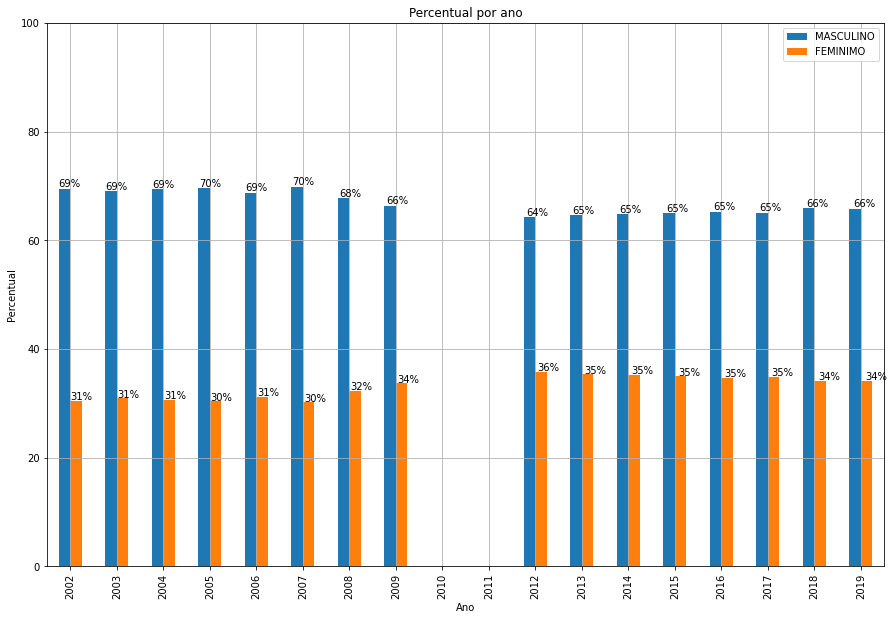

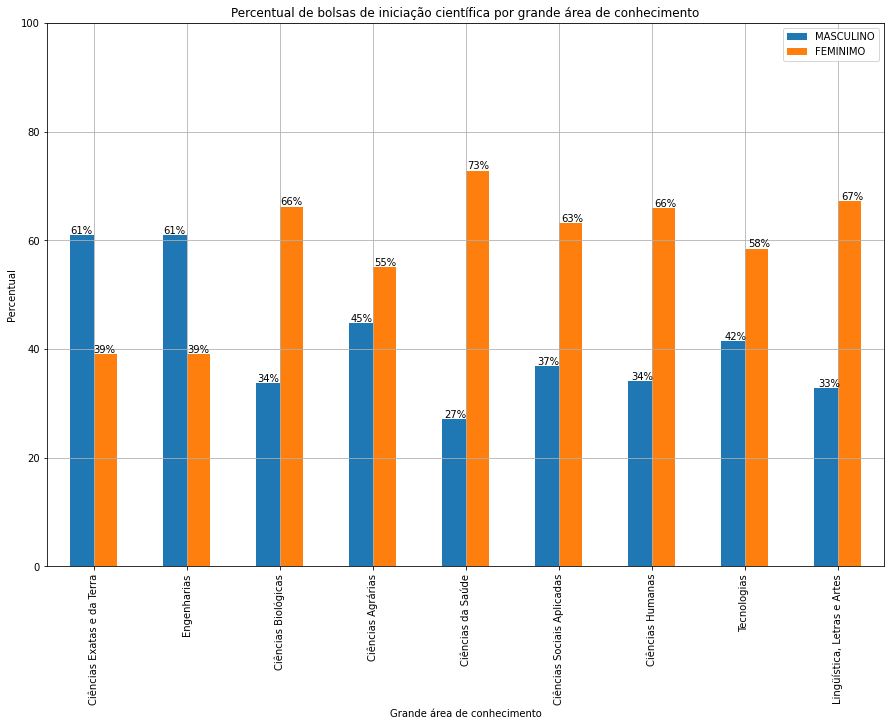

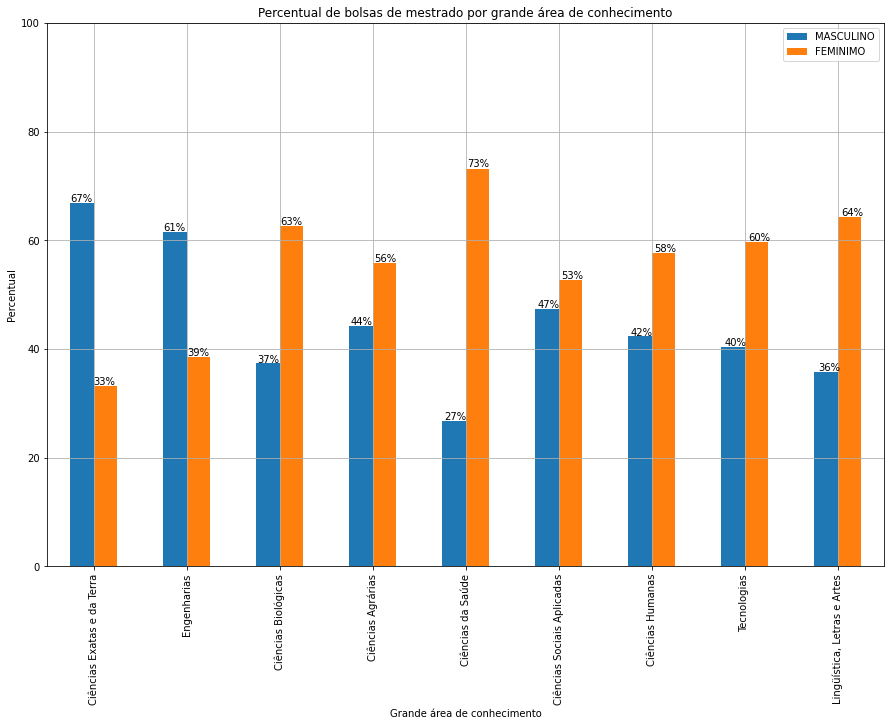

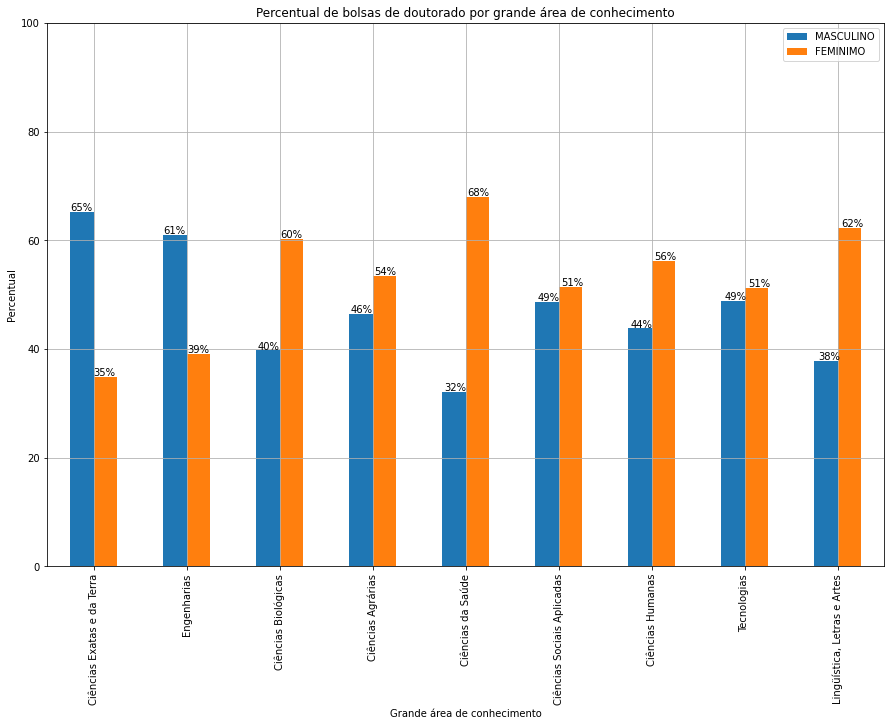

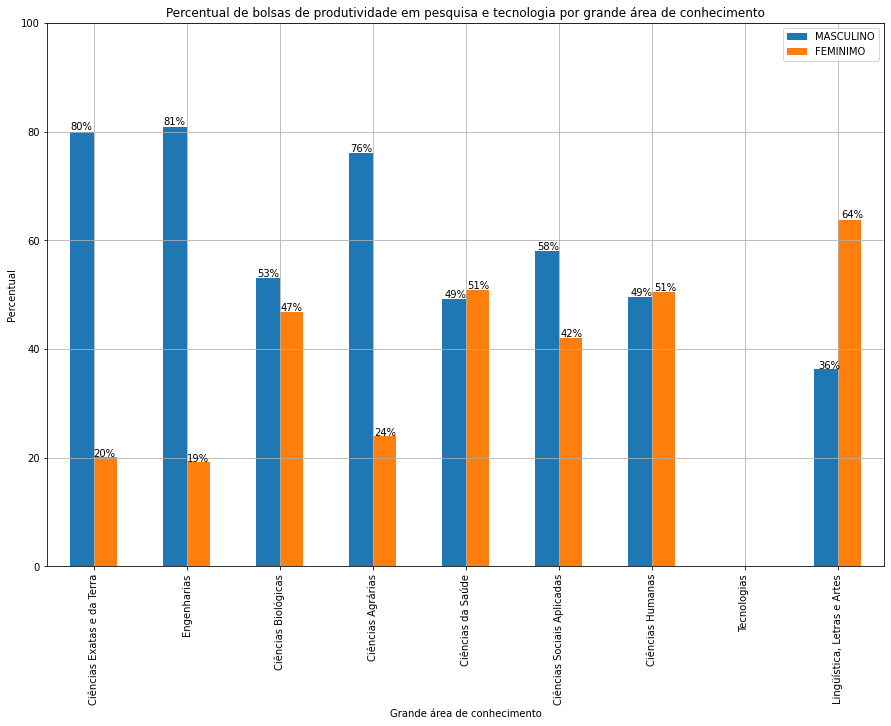

In [144]:
por_ano(df_pq)

por_curso(df_pq, grau='Bolsas de Iniciação Científica')
por_curso(df_pq, grau='Bolsas de Mestrado')
por_curso(df_pq, grau='Bolsas de Doutorado')
por_curso(df_pq, grau='Bolsas de Produtividade em Pesquisa e Tecnologia')
